### Seeking of anomaly numbers of views of ads, calculation of CR 

In [76]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import zipfile
import numpy as np

In [3]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [4]:
path_to_zip_file = zipfile.ZipFile('/home/jupyter-v.hohlov-16/Lesson_6/ads.zip')

In [58]:
ads_client = pd.read_csv(path_to_zip_file.open('ads_clients_data.csv'))

In [56]:
ads_data = pd.read_csv(path_to_zip_file.open('ads_data.csv'))

In [10]:
ads_data.dtypes

date                      object
time                      object
event                     object
platform                  object
ad_id                      int64
client_union_id            int64
campaign_union_id          int64
ad_cost_type              object
ad_cost                  float64
has_video                  int64
target_audience_count      int64
dtype: object

In [11]:
clients_data.dtypes

date               object
client_union_id     int64
community_id        int64
create_date        object
dtype: object

In [12]:
ads_data

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501
...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-05,2019-04-05 20:59:52,view,web,112583,111818,112260,CPM,210.1,0,22392
999996,2019-04-05,2019-04-05 20:59:52,view,android,112583,111818,112260,CPM,210.1,0,22392
999997,2019-04-05,2019-04-05 20:59:52,click,web,112583,111818,112260,CPM,210.1,0,22392
999998,2019-04-05,2019-04-05 20:59:52,view,web,113350,113036,113251,CPM,183.3,0,571929


#### At first, analyze mean of clicks and views in noisy data and missed values

In [46]:
mean_of_events = ads_data.groupby(['ad_id', 'event'], as_index = False)\
                         .agg({'date': 'count'})\
                         .pivot(values = 'date', index = 'ad_id', columns = 'event')\
                         .fillna(0)\
                         .agg({'click': 'mean', 'view': 'mean'})\
                         .round()

click    113.0
view     923.0
dtype: float64

#### Lets see on distribution of views getting logarithm of data

In [72]:
df = ads_data.groupby(['ad_id', 'event'], as_index = False)\
        .agg({'date': 'count'})\
        .pivot(values = 'date', index = 'ad_id', columns = 'event')\
        .fillna(0)

In [69]:
df['log_view'] = np.log(df['view'] + 0.000001)

In [70]:
df

event,click,view,log_view
ad_id,,,
2,1.0,101.0,4.615121
3,3.0,184.0,5.214936
1902,1.0,41.0,3.713572
2064,0.0,35.0,3.555348
2132,1.0,58.0,4.060443
...,...,...,...
122004,4.0,100.0,4.605170
122013,0.0,156.0,5.049856
122023,0.0,68.0,4.219508


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


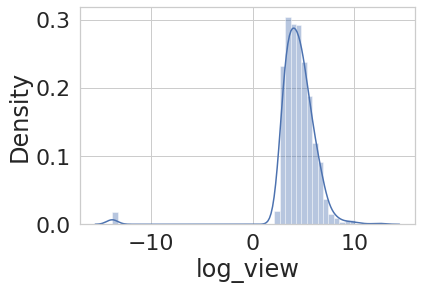

In [71]:
sns.distplot(df.log_view)

In [97]:
df.query('view == 0').count()

event
click    9
view     9
dtype: int64

#### Now finding average number of views of one ads considering ads with no views. After that calculate rolling mean with window = 2 elements.  

In [169]:
rolling_mean_of_views = ads_data.query('event == "view"')\
                                .groupby(['date', 'ad_id'], as_index = False)\
                                .agg({'event': 'count'})\
                                .rename(columns = {'event': 'views_amount'})\
                                .groupby('date')\
                                .agg({'views_amount': 'mean'})\
                                .rolling(2).mean()\
                                .round()

In [182]:
simple_mean_of_views = ads_data.query('event == "view"')\
                                .groupby(['date', 'ad_id'], as_index = False)\
                                .agg({'event': 'count'})\
                                .rename(columns = {'event': 'views_amount'})\
                                .groupby('date')\
                                .agg({'views_amount': 'mean'})\

#### Lets visualize simple mean views per day and rolling mean of the same 

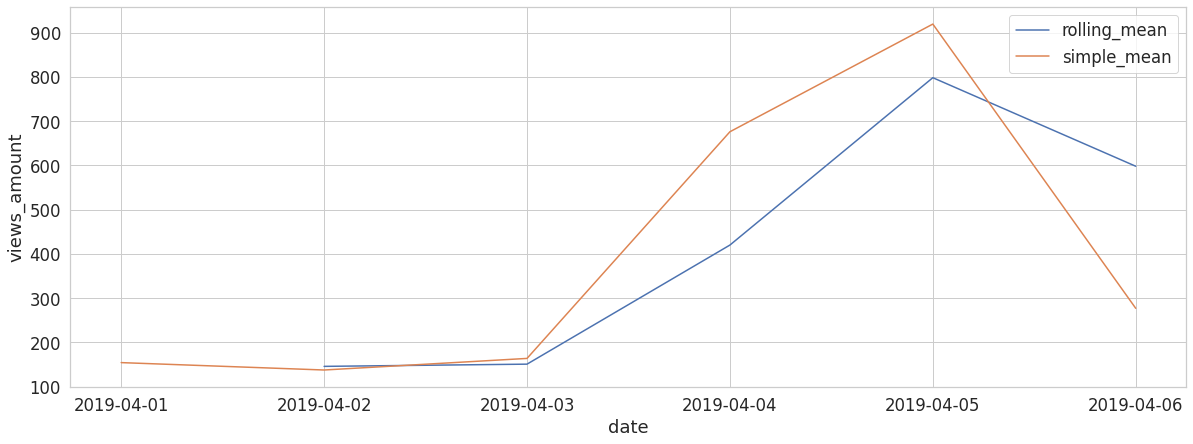

In [200]:
sns.lineplot(y = rolling_mean_of_views.views_amount, x = rolling_mean_of_views.index, label = 'rolling_mean')
sns.lineplot(y = simple_mean_of_views.views_amount, x = simple_mean_of_views.index, label = 'simple_mean')

In [242]:
rolling_mean_of_views

,views_amount
date,
2019-04-01,NaN
2019-04-02,146.0
2019-04-03,151.0
2019-04-04,420.0
2019-04-05,798.0
2019-04-06,598.0


In [243]:
simple_mean_of_views

,views_amount
date,
2019-04-01,154.482270
2019-04-02,137.786982
2019-04-03,163.952778
2019-04-04,675.901720
2019-04-05,919.109677
2019-04-06,277.122727


In [244]:
main_df = rolling_mean_of_views.merge(simple_mean_of_views, on = 'date').dropna(0)

#### Seek day with anomaly value, e.g. with maximum difference between rolling mean and simple mean

In [245]:
main_df['diff'] = main_df['views_amount_x'] - main_df['views_amount_y']

# OR: main_df['views_amount_x'].substract(main_df['views_amount_y'])

In [246]:
main_df

,views_amount_x,views_amount_y,diff
date,,,
2019-04-02,146.0,137.786982,8.213018
2019-04-03,151.0,163.952778,-12.952778
2019-04-04,420.0,675.901720,-255.901720
2019-04-05,798.0,919.109677,-121.109677
2019-04-06,598.0,277.122727,320.877273


In [247]:
anomaly_day = main_df['diff'].idxmax()
anomaly_day

'2019-04-06'

In [248]:
main_df.rename(columns = {'views_amount_x': 'rolling_mean_of_views',
                         'views_amount_y': 'simple_mean_of_views',
                         'diff': 'abs_anomaly'})

,rolling_mean_of_views,simple_mean_of_views,abs_anomaly
date,,,
2019-04-02,146.0,137.786982,8.213018
2019-04-03,151.0,163.952778,-12.952778
2019-04-04,420.0,675.901720,-255.901720
2019-04-05,798.0,919.109677,-121.109677
2019-04-06,598.0,277.122727,320.877273


#### Lets calculate CR from account creation to launching of first ads.


In [140]:
full_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [141]:
full_data['diff'] = full_data.groupby('client_union_id')\
                     .apply(lambda x: (x.date - x.create_date).min())\
        

In [148]:
full_data.query('diff != "NaT"').shape[0]

838

In [146]:
full_data.shape[0]

1000000

In [154]:
round(100 * (full_data.query('diff != "NaT"').shape[0] / ads_client.shape[0]), 2)

0.69

#### Lets divide clients on categories via time gaps from account creation to launching of first ads

In [167]:
full_data = full_data.reset_index(drop = True)
full_data

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date,diff
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaT
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,98 days
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaT
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaT
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-04,2019-04-04 18:07:25,view,web,43921,30712,43920,CPM,196.7,0,7807,2019-03-04,NaT
999996,2019-04-04,2019-04-04 18:29:06,view,ios,43921,30712,43920,CPM,196.7,0,7807,2019-03-04,NaT
999997,2019-04-04,2019-04-04 18:55:46,view,web,43921,30712,43920,CPM,196.7,0,7807,2019-03-04,NaT
999998,2019-04-04,2019-04-04 19:21:09,view,android,43921,30712,43920,CPM,196.7,0,7807,2019-03-04,NaT


In [170]:
full_data.dtypes

date                      datetime64[ns]
time                              object
event                             object
platform                          object
ad_id                              int64
client_union_id                    int64
campaign_union_id                  int64
ad_cost_type                      object
ad_cost                          float64
has_video                          int64
target_audience_count              int64
create_date               datetime64[ns]
diff                     timedelta64[ns]
dtype: object

In [174]:
full_data['diff']

0            NaT
1        98 days
2            NaT
3            NaT
4            NaT
           ...  
999995       NaT
999996       NaT
999997       NaT
999998       NaT
999999       NaT
Name: diff, Length: 1000000, dtype: timedelta64[ns]

In [218]:
full_data['client_category'] = pd.cut(full_data['diff'], bins = pd.to_timedelta(['0D', '30D', '90D', '180D', '365D']), labels = ['0-30', '31-90', '91-180', '181-365'])                                     

In [219]:
user_allocation = full_data['client_category'].value_counts()

In [220]:
user_allocation

91-180     396
31-90      263
181-365    168
0-30        11
Name: client_category, dtype: int64

In [226]:
user_allocation_df = pd.DataFrame(data = user_allocation).reset_index()

In [227]:
user_allocation_df

,index,client_category
0,91-180,396
1,31-90,263
2,181-365,168
3,0-30,11


In [229]:
user_allocation_df['index']

0     91-180
1      31-90
2    181-365
3       0-30
Name: index, dtype: category
Categories (4, object): ['0-30' < '31-90' < '91-180' < '181-365']

In [230]:
user_allocation_df['client_category']

0    396
1    263
2    168
3     11
Name: client_category, dtype: int64